# Changes

## v04: 2024-11-23
* 외부에서 데이터를 가져오는 방식은 외부 환경의 변화에 따라 계속해서 에러가 생길 수 밖에 없어(e.g. yahoo finance 웹페이지의 구조가 변화하면, 이 웹페이지에서 데이터를 긁어오는 yfinance의 함수에 에러가 생김) 사전에 주어진 파일을 읽어들여 생성한 데이터프레임을 가지고 실습을 진행하는 방식으로 변경하였음
* 실습시 이 노트북 파일(데이터과학개론_코드_v04.ipynb)과 같이 배포되는 다음 파일들을 구글 Colab의 실행 공간에 업로드한 후 노트북을 실행해주세요
  * google_earnings.csv
  * google_price.csv
  * meta_price.csv

## v03: 2023.09.01
* 기존 yahoo_fin 패키지의 get_earnings_history API가 더 이상 제대로 동작하지 않는 문제가 있어 해당 부분만 yfinance 패키지를 사용하도록 변경
* 구글의 주식 분할에 따른 eps 값 변경이 2020년 이전 데이터에도 모두 반영된 것으로 보임. eps 값 스케일 변화에 맞춰 일부 값들을 변경하였음

## v02: 2022.11.14

* 페이스북의 ticker를 fb에서 meta로 변경
* 회귀분석에 사용되는 구글 데이터의 기간을 2015~2019년으로 변경. 구글이 1:20으로 주식분할을 하면서 야후 파이낸스에서 구글의 eps 데이터가 2020년 분까지만 수정된 것으로 보임.
* 이와 같은 수정으로 인해 코드 출력 결과가 기존 교재의 결과와 달라질 수 있습니다. 결과의 디테일보다는 코드의 의도를 이해하는데 초점을 맞추어 실습을 수행하시면 좋겠습니다.

# pandas와 numpy를 이용한 데이터 가공

## 데이터프레임의 생성

### Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython
from datetime import datetime
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pickle
from pandas.plotting import scatter_matrix
from dateutil.relativedelta import relativedelta
from sklearn.decomposition import PCA

In [2]:
earning_df = pd.read_csv("google_earnings.csv")

In [3]:
earning_df["startdatetime"] = earning_df['Earnings Date'].map(
    lambda date_str: (datetime.strptime(date_str[:-3], "%b %d, %Y, %I %p")).strftime("%Y-%m-%dT%H:%M:%S")
)

In [4]:
earning_df.rename(
    {"Reported EPS": "epsactual",
     "EPS Estimate": "epsestimate",
     "Surprise(%)": "epssurprisepct"},
    axis=1,
    inplace=True)

In [5]:
earning_df["epsactual"] = earning_df["epsactual"].map(
    lambda x: float(x)
)
earning_df["epsestimate"] = earning_df["epsestimate"].map(
    lambda x: float(x)
)
earning_df["epssurprisepct"] = earning_df["epssurprisepct"].map(
    lambda x: float(x)
)

In [6]:
earning_df.dtypes

,0
Symbol,object
Company,object
Earnings Date,object
epsestimate,float64
epsactual,float64
epssurprisepct,float64
startdatetime,object


In [7]:
earning_df.head()

,Symbol,Company,Earnings Date,epsestimate,epsactual,epssurprisepct,startdatetime
0,GOOGL,Alphabet Inc,"Oct 27, 2025, 4 PMEDT",NaN,NaN,NaN,2025-10-27T16:00:00
1,GOOGL,Alphabet Inc,"Jul 21, 2025, 4 PMEDT",NaN,NaN,NaN,2025-07-21T16:00:00
2,GOOGL,Alphabet Inc,"Apr 23, 2025, 4 PMEDT",NaN,NaN,NaN,2025-04-23T16:00:00
3,GOOGL,Alphabet Inc,"Jan 28, 2025, 4 PMEST",2.12,NaN,NaN,2025-01-28T16:00:00
4,GOOGL,Alphabet Inc.,"Oct 29, 2024, 4 PMEDT",1.85,2.12,14.91,2024-10-29T16:00:00


In [8]:
earning_df.to_csv('earning.csv', index=False)

In [9]:
earning_df_from_csv = pd.read_csv('earning.csv')
earning_df_from_csv.head()

,Symbol,Company,Earnings Date,epsestimate,epsactual,epssurprisepct,startdatetime
0,GOOGL,Alphabet Inc,"Oct 27, 2025, 4 PMEDT",NaN,NaN,NaN,2025-10-27T16:00:00
1,GOOGL,Alphabet Inc,"Jul 21, 2025, 4 PMEDT",NaN,NaN,NaN,2025-07-21T16:00:00
2,GOOGL,Alphabet Inc,"Apr 23, 2025, 4 PMEDT",NaN,NaN,NaN,2025-04-23T16:00:00
3,GOOGL,Alphabet Inc,"Jan 28, 2025, 4 PMEST",2.12,NaN,NaN,2025-01-28T16:00:00
4,GOOGL,Alphabet Inc.,"Oct 29, 2024, 4 PMEDT",1.85,2.12,14.91,2024-10-29T16:00:00


In [10]:
earning_array = earning_df.values
earning_array[:2]

array([['GOOGL', 'Alphabet Inc', 'Oct 27, 2025, 4 PMEDT', nan, nan, nan,
        '2025-10-27T16:00:00'],
       ['GOOGL', 'Alphabet Inc', 'Jul 21, 2025, 4 PMEDT', nan, nan, nan,
        '2025-07-21T16:00:00']], dtype=object)

In [11]:
earning_df_from_array = pd.DataFrame(data=earning_array, columns=earning_df.columns.values)
earning_df_from_array.head()

,Symbol,Company,Earnings Date,epsestimate,epsactual,epssurprisepct,startdatetime
0,GOOGL,Alphabet Inc,"Oct 27, 2025, 4 PMEDT",NaN,NaN,NaN,2025-10-27T16:00:00
1,GOOGL,Alphabet Inc,"Jul 21, 2025, 4 PMEDT",NaN,NaN,NaN,2025-07-21T16:00:00
2,GOOGL,Alphabet Inc,"Apr 23, 2025, 4 PMEDT",NaN,NaN,NaN,2025-04-23T16:00:00
3,GOOGL,Alphabet Inc,"Jan 28, 2025, 4 PMEST",2.12,NaN,NaN,2025-01-28T16:00:00
4,GOOGL,Alphabet Inc.,"Oct 29, 2024, 4 PMEDT",1.85,2.12,14.91,2024-10-29T16:00:00


## 데이터의 선택과 샘플링

In [12]:
earning_cols = earning_df[["startdatetime", "epsactual"]]
earning_cols.head()

,startdatetime,epsactual
0,2025-10-27T16:00:00,NaN
1,2025-07-21T16:00:00,NaN
2,2025-04-23T16:00:00,NaN
3,2025-01-28T16:00:00,NaN
4,2024-10-29T16:00:00,2.12


In [13]:
earning_df["epsactual"]

,epsactual
0,NaN
1,NaN
2,NaN
3,NaN
4,2.12
...,...
80,0.04
81,0.03
82,0.03
83,0.02


In [14]:
type(earning_df["epsactual"]), type(earning_df[["startdatetime", "epsactual"]])

(pandas.core.series.Series, pandas.core.frame.DataFrame)

In [15]:
earning_rows = earning_df[1:3]
earning_rows

,Symbol,Company,Earnings Date,epsestimate,epsactual,epssurprisepct,startdatetime
1,GOOGL,Alphabet Inc,"Jul 21, 2025, 4 PMEDT",NaN,NaN,NaN,2025-07-21T16:00:00
2,GOOGL,Alphabet Inc,"Apr 23, 2025, 4 PMEDT",NaN,NaN,NaN,2025-04-23T16:00:00


In [16]:
earning_df_new_index = pd.DataFrame(
    data=earning_array,
    columns=earning_df.columns.values,
    index=range(1, len(earning_df) + 1))
earning_df_new_index.head()

,Symbol,Company,Earnings Date,epsestimate,epsactual,epssurprisepct,startdatetime
1,GOOGL,Alphabet Inc,"Oct 27, 2025, 4 PMEDT",NaN,NaN,NaN,2025-10-27T16:00:00
2,GOOGL,Alphabet Inc,"Jul 21, 2025, 4 PMEDT",NaN,NaN,NaN,2025-07-21T16:00:00
3,GOOGL,Alphabet Inc,"Apr 23, 2025, 4 PMEDT",NaN,NaN,NaN,2025-04-23T16:00:00
4,GOOGL,Alphabet Inc,"Jan 28, 2025, 4 PMEST",2.12,NaN,NaN,2025-01-28T16:00:00
5,GOOGL,Alphabet Inc.,"Oct 29, 2024, 4 PMEDT",1.85,2.12,14.91,2024-10-29T16:00:00


In [17]:
earning_df_new_index[1:3]

,Symbol,Company,Earnings Date,epsestimate,epsactual,epssurprisepct,startdatetime
2,GOOGL,Alphabet Inc,"Jul 21, 2025, 4 PMEDT",NaN,NaN,NaN,2025-07-21T16:00:00
3,GOOGL,Alphabet Inc,"Apr 23, 2025, 4 PMEDT",NaN,NaN,NaN,2025-04-23T16:00:00


In [18]:
earning_df_new_index.iloc[1:3]

,Symbol,Company,Earnings Date,epsestimate,epsactual,epssurprisepct,startdatetime
2,GOOGL,Alphabet Inc,"Jul 21, 2025, 4 PMEDT",NaN,NaN,NaN,2025-07-21T16:00:00
3,GOOGL,Alphabet Inc,"Apr 23, 2025, 4 PMEDT",NaN,NaN,NaN,2025-04-23T16:00:00


In [19]:
earning_df_new_index.loc[1:3]

,Symbol,Company,Earnings Date,epsestimate,epsactual,epssurprisepct,startdatetime
1,GOOGL,Alphabet Inc,"Oct 27, 2025, 4 PMEDT",NaN,NaN,NaN,2025-10-27T16:00:00
2,GOOGL,Alphabet Inc,"Jul 21, 2025, 4 PMEDT",NaN,NaN,NaN,2025-07-21T16:00:00
3,GOOGL,Alphabet Inc,"Apr 23, 2025, 4 PMEDT",NaN,NaN,NaN,2025-04-23T16:00:00


In [20]:
earning_df_new_index.iloc[1:4,[2,3]]

,Earnings Date,epsestimate
2,"Jul 21, 2025, 4 PMEDT",NaN
3,"Apr 23, 2025, 4 PMEDT",NaN
4,"Jan 28, 2025, 4 PMEST",2.12


In [21]:
earning_df_new_index.loc[1:3,["startdatetime", "epsactual"]]

,startdatetime,epsactual
1,2025-10-27T16:00:00,NaN
2,2025-07-21T16:00:00,NaN
3,2025-04-23T16:00:00,NaN


In [22]:
earning_df[earning_df["epsactual"] > 0.8]

,Symbol,Company,Earnings Date,epsestimate,epsactual,epssurprisepct,startdatetime
4,GOOGL,Alphabet Inc.,"Oct 29, 2024, 4 PMEDT",1.85,2.12,14.91,2024-10-29T16:00:00
5,GOOGL,Alphabet Inc.,"Jul 23, 2024, 4 PMEDT",1.84,1.89,2.47,2024-07-23T16:00:00
6,GOOGL,Alphabet Inc.,"Apr 25, 2024, 4 PMEDT",1.51,1.89,24.77,2024-04-25T16:00:00
7,GOOGL,Alphabet Inc.,"Jan 30, 2024, 4 PMEST",1.59,1.64,2.98,2024-01-30T16:00:00
8,GOOGL,Alphabet Inc.,"Oct 24, 2023, 4 PMEDT",1.45,1.55,6.84,2023-10-24T16:00:00
9,GOOGL,Alphabet Inc.,"Jul 25, 2023, 4 PMEDT",1.34,1.44,7.54,2023-07-25T16:00:00
10,GOOGL,Alphabet Inc.,"Apr 25, 2023, 4 PMEDT",1.07,1.17,9.72,2023-04-25T16:00:00
11,GOOGL,Alphabet Inc.,"Feb 02, 2023, 4 PMEST",1.18,1.05,-10.73,2023-02-02T16:00:00
12,GOOGL,Alphabet Inc.,"Oct 25, 2022, 4 PMEDT",1.25,1.06,-15.14,2022-10-25T16:00:00
13,GOOGL,Alphabet Inc.,"Jul 26, 2022, 4 PMEDT",1.28,1.21,-5.41,2022-07-26T16:00:00


In [23]:
earning_df[(earning_df["epsactual"] > 0.8) &
           (earning_df["startdatetime"] > "2021-01-01")]

,Symbol,Company,Earnings Date,epsestimate,epsactual,epssurprisepct,startdatetime
4,GOOGL,Alphabet Inc.,"Oct 29, 2024, 4 PMEDT",1.85,2.12,14.91,2024-10-29T16:00:00
5,GOOGL,Alphabet Inc.,"Jul 23, 2024, 4 PMEDT",1.84,1.89,2.47,2024-07-23T16:00:00
6,GOOGL,Alphabet Inc.,"Apr 25, 2024, 4 PMEDT",1.51,1.89,24.77,2024-04-25T16:00:00
7,GOOGL,Alphabet Inc.,"Jan 30, 2024, 4 PMEST",1.59,1.64,2.98,2024-01-30T16:00:00
8,GOOGL,Alphabet Inc.,"Oct 24, 2023, 4 PMEDT",1.45,1.55,6.84,2023-10-24T16:00:00
9,GOOGL,Alphabet Inc.,"Jul 25, 2023, 4 PMEDT",1.34,1.44,7.54,2023-07-25T16:00:00
10,GOOGL,Alphabet Inc.,"Apr 25, 2023, 4 PMEDT",1.07,1.17,9.72,2023-04-25T16:00:00
11,GOOGL,Alphabet Inc.,"Feb 02, 2023, 4 PMEST",1.18,1.05,-10.73,2023-02-02T16:00:00
12,GOOGL,Alphabet Inc.,"Oct 25, 2022, 4 PMEDT",1.25,1.06,-15.14,2022-10-25T16:00:00
13,GOOGL,Alphabet Inc.,"Jul 26, 2022, 4 PMEDT",1.28,1.21,-5.41,2022-07-26T16:00:00


In [24]:
index = np.where((earning_df["epsactual"] > 0.8) &
                 (earning_df["startdatetime"] > "2021-01-01"))
index

(array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),)

In [25]:
earning_df.iloc[index]

,Symbol,Company,Earnings Date,epsestimate,epsactual,epssurprisepct,startdatetime
4,GOOGL,Alphabet Inc.,"Oct 29, 2024, 4 PMEDT",1.85,2.12,14.91,2024-10-29T16:00:00
5,GOOGL,Alphabet Inc.,"Jul 23, 2024, 4 PMEDT",1.84,1.89,2.47,2024-07-23T16:00:00
6,GOOGL,Alphabet Inc.,"Apr 25, 2024, 4 PMEDT",1.51,1.89,24.77,2024-04-25T16:00:00
7,GOOGL,Alphabet Inc.,"Jan 30, 2024, 4 PMEST",1.59,1.64,2.98,2024-01-30T16:00:00
8,GOOGL,Alphabet Inc.,"Oct 24, 2023, 4 PMEDT",1.45,1.55,6.84,2023-10-24T16:00:00
9,GOOGL,Alphabet Inc.,"Jul 25, 2023, 4 PMEDT",1.34,1.44,7.54,2023-07-25T16:00:00
10,GOOGL,Alphabet Inc.,"Apr 25, 2023, 4 PMEDT",1.07,1.17,9.72,2023-04-25T16:00:00
11,GOOGL,Alphabet Inc.,"Feb 02, 2023, 4 PMEST",1.18,1.05,-10.73,2023-02-02T16:00:00
12,GOOGL,Alphabet Inc.,"Oct 25, 2022, 4 PMEDT",1.25,1.06,-15.14,2022-10-25T16:00:00
13,GOOGL,Alphabet Inc.,"Jul 26, 2022, 4 PMEDT",1.28,1.21,-5.41,2022-07-26T16:00:00


In [26]:
len(earning_df.sample(n=5))

5

In [27]:
len(earning_df.sample(frac=0.5)), len(earning_df)

(42, 85)

In [28]:
earning_df = earning_df[["startdatetime",
                         "epsactual",
                         "epssurprisepct"]]
earning_df.head()

,startdatetime,epsactual,epssurprisepct
0,2025-10-27T16:00:00,NaN,NaN
1,2025-07-21T16:00:00,NaN,NaN
2,2025-04-23T16:00:00,NaN,NaN
3,2025-01-28T16:00:00,NaN,NaN
4,2024-10-29T16:00:00,2.12,14.91


## 누락 데이터의 처리

In [29]:
notnull_firstrow = earning_df[earning_df["epsactual"].notnull()].head().iloc[0]

In [30]:
earning_fillna = earning_df.fillna(
    {'epsactual': notnull_firstrow["epsactual"],
     'epssurprisepct': notnull_firstrow["epssurprisepct"]})
earning_fillna.head()

,startdatetime,epsactual,epssurprisepct
0,2025-10-27T16:00:00,2.12,14.91
1,2025-07-21T16:00:00,2.12,14.91
2,2025-04-23T16:00:00,2.12,14.91
3,2025-01-28T16:00:00,2.12,14.91
4,2024-10-29T16:00:00,2.12,14.91


In [31]:
earning_sample = earning_df.dropna()
len(earning_sample), len(earning_df)

(81, 85)

In [32]:
earning_sample = earning_sample.reset_index(drop=True)
earning_sample.head()

,startdatetime,epsactual,epssurprisepct
0,2024-10-29T16:00:00,2.12,14.91
1,2024-07-23T16:00:00,1.89,2.47
2,2024-04-25T16:00:00,1.89,24.77
3,2024-01-30T16:00:00,1.64,2.98
4,2023-10-24T16:00:00,1.55,6.84


## 중복 데이터의 제거

In [33]:
earning_dup = pd.concat([earning_sample[:1],
                         earning_sample]).reset_index(drop=True)
earning_dup.head()

,startdatetime,epsactual,epssurprisepct
0,2024-10-29T16:00:00,2.12,14.91
1,2024-10-29T16:00:00,2.12,14.91
2,2024-07-23T16:00:00,1.89,2.47
3,2024-04-25T16:00:00,1.89,24.77
4,2024-01-30T16:00:00,1.64,2.98


In [34]:
earning_dup.drop_duplicates(subset=["startdatetime"],
                            keep="first", inplace=True)
earning_dup.head()

,startdatetime,epsactual,epssurprisepct
0,2024-10-29T16:00:00,2.12,14.91
2,2024-07-23T16:00:00,1.89,2.47
3,2024-04-25T16:00:00,1.89,24.77
4,2024-01-30T16:00:00,1.64,2.98
5,2023-10-24T16:00:00,1.55,6.84


## 데이터 연산

In [35]:
earning_sample.dtypes

,0
startdatetime,object
epsactual,float64
epssurprisepct,float64


In [36]:
pd.options.mode.chained_assignment = None

In [37]:
earning_sample["date"] = earning_sample.apply(
    lambda row: row["startdatetime"].split("T")[0], axis=1)

In [38]:
earning_sample.head()

,startdatetime,epsactual,epssurprisepct,date
0,2024-10-29T16:00:00,2.12,14.91,2024-10-29
1,2024-07-23T16:00:00,1.89,2.47,2024-07-23
2,2024-04-25T16:00:00,1.89,24.77,2024-04-25
3,2024-01-30T16:00:00,1.64,2.98,2024-01-30
4,2023-10-24T16:00:00,1.55,6.84,2023-10-24


In [39]:
earning_sample["date"] = pd.to_datetime(earning_sample["date"],
                                        format="%Y-%m-%d")

In [40]:
earning_sample.dtypes

,0
startdatetime,object
epsactual,float64
epssurprisepct,float64
date,datetime64[ns]


In [41]:
earning_sample["startdatetime"].map(
    lambda startdatetime: startdatetime.split("T")[0])

,startdatetime
0,2024-10-29
1,2024-07-23
2,2024-04-25
3,2024-01-30
4,2023-10-24
...,...
76,2005-10-20
77,2005-07-21
78,2005-04-21
79,2005-02-01


In [42]:
(pd.DataFrame({"a": [1, 2], "b": [3, 4]})
   .applymap(lambda x: x + 1))

<ipython-input-42-f292292cb65e>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(lambda x: x + 1))


,a,b
0,2,4
1,3,5


In [43]:
earning_sample["startdatetime"].apply(
    lambda startdatetime: startdatetime.split("T")[0])

,startdatetime
0,2024-10-29
1,2024-07-23
2,2024-04-25
3,2024-01-30
4,2023-10-24
...,...
76,2005-10-20
77,2005-07-21
78,2005-04-21
79,2005-02-01


## 정렬

In [44]:
price = pd.read_csv("google_price.csv", index_col=0, parse_dates=True)
type(price)

pandas.core.frame.DataFrame

In [45]:
price.head()

,open,high,low,close,adjclose,volume,ticker
2004-08-19,2.502503,2.604104,2.401401,2.511011,2.504808,893181924,GOOGL
2004-08-20,2.527778,2.729730,2.515015,2.710460,2.703765,456686856,GOOGL
2004-08-23,2.771522,2.839840,2.728979,2.737738,2.730976,365122512,GOOGL
2004-08-24,2.783784,2.792793,2.591842,2.624374,2.617892,304946748,GOOGL
2004-08-25,2.626627,2.702703,2.599600,2.652653,2.646101,183772044,GOOGL


In [46]:
price.to_csv("price.csv", index=True)

In [47]:
price_sort_index = price.sort_index(ascending=False)
price_sort_index.head()

,open,high,low,close,adjclose,volume,ticker
2024-11-21,173.899994,174.130005,163.699997,167.630005,167.630005,59641100,GOOGL
2024-11-20,177.339996,177.679993,173.779999,175.979996,175.979996,18997100,GOOGL
2024-11-19,173.720001,178.869995,173.559998,178.119995,178.119995,23434900,GOOGL
2024-11-18,173.419998,175.440002,172.899994,175.300003,175.300003,20206600,GOOGL
2024-11-15,173.729996,174.139999,171.220001,172.490005,172.490005,32504600,GOOGL


In [48]:
price_sort_values = price.sort_values(by='close', ascending=False)
price_sort_values.head()

,open,high,low,close,adjclose,volume,ticker
2024-07-10,189.149994,191.750000,189.029999,191.179993,190.926636,15952500,GOOGL
2024-07-05,185.860001,190.860001,185.800003,190.600006,190.347427,20967500,GOOGL
2024-07-08,189.899994,190.169998,187.779999,189.029999,188.779495,21035900,GOOGL
2024-07-09,190.309998,191.360001,188.720001,188.979996,188.729568,15121400,GOOGL
2024-07-15,184.919998,188.240005,184.919998,186.529999,186.282806,16474000,GOOGL


## 그룹과 집계

In [49]:
price["month"] = price.index.map(
    lambda date: date.strftime("%Y") + "-" + date.strftime("%m"))
price.head()

,open,high,low,close,adjclose,volume,ticker,month
2004-08-19,2.502503,2.604104,2.401401,2.511011,2.504808,893181924,GOOGL,2004-08
2004-08-20,2.527778,2.729730,2.515015,2.710460,2.703765,456686856,GOOGL,2004-08
2004-08-23,2.771522,2.839840,2.728979,2.737738,2.730976,365122512,GOOGL,2004-08
2004-08-24,2.783784,2.792793,2.591842,2.624374,2.617892,304946748,GOOGL,2004-08
2004-08-25,2.626627,2.702703,2.599600,2.652653,2.646101,183772044,GOOGL,2004-08


In [50]:
price_mean = (price
             .groupby(by="month")[["open", "close"]]
             .agg(open_mean=("open", "mean"),
                  close_mean=("close", "mean"))
             .reset_index())
price_mean.head()

,month,open_mean,close_mean
0,2004-08,2.637610,2.634190
1,2004-09,2.802231,2.833512
2,2004-10,3.816078,3.834608
3,2004-11,4.458601,4.441823
4,2004-12,4.539460,4.548799


In [51]:
price_mean = (price
              .groupby(by="month")
              .agg({"open": "mean", "close": "mean"})
              .reset_index())
price_mean.head()

,month,open,close
0,2004-08,2.637610,2.634190
1,2004-09,2.802231,2.833512
2,2004-10,3.816078,3.834608
3,2004-11,4.458601,4.441823
4,2004-12,4.539460,4.548799


In [52]:
price_mean.rename(
    {"open": "open_mean", "close": "close_mean"},
    axis=1,
    inplace=True)
price_mean.head()

,month,open_mean,close_mean
0,2004-08,2.637610,2.634190
1,2004-09,2.802231,2.833512
2,2004-10,3.816078,3.834608
3,2004-11,4.458601,4.441823
4,2004-12,4.539460,4.548799


In [53]:
(price
 .groupby(by="month")
 .agg({"open": "min", "close": "max"})
 .reset_index()
 .head())

,month,open,close
0,2004-08,2.502503,2.737738
1,2004-09,2.482232,3.280280
2,2004-10,3.273273,4.837337
3,2004-11,4.115866,4.905656
4,2004-12,4.260511,4.944945


In [54]:
(price
 .groupby(by="month")[["open", "close"]]
 .mean()
 .reset_index()
 .head())

,month,open,close
0,2004-08,2.637610,2.634190
1,2004-09,2.802231,2.833512
2,2004-10,3.816078,3.834608
3,2004-11,4.458601,4.441823
4,2004-12,4.539460,4.548799


In [55]:
(price
 .groupby(by="month")[["open", "close"]]
 .max()
 .reset_index()
 .head())

,month,open,close
0,2004-08,2.783784,2.737738
1,2004-09,3.250751,3.280280
2,2004-10,4.977227,4.837337
3,2004-11,4.974474,4.905656
4,2004-12,4.985736,4.944945


In [56]:
price.groupby(by="month")[["open", "close"]].mean().head()

,open,close
month,,
2004-08,2.637610,2.634190
2004-09,2.802231,2.833512
2004-10,3.816078,3.834608
2004-11,4.458601,4.441823
2004-12,4.539460,4.548799


In [57]:
roll = earning_sample["epsactual"].rolling(window=4)
earning_sample["eps_ttm"] = roll.sum().shift(-3)
earning_sample.head()

,startdatetime,epsactual,epssurprisepct,date,eps_ttm
0,2024-10-29T16:00:00,2.12,14.91,2024-10-29,7.54
1,2024-07-23T16:00:00,1.89,2.47,2024-07-23,6.97
2,2024-04-25T16:00:00,1.89,24.77,2024-04-25,6.52
3,2024-01-30T16:00:00,1.64,2.98,2024-01-30,5.80
4,2023-10-24T16:00:00,1.55,6.84,2023-10-24,5.21


In [58]:
roll.sum().head()

,epsactual
0,NaN
1,NaN
2,NaN
3,7.54
4,6.97


In [59]:
earning_sample["eps_ttm_diff"] = (
    earning_sample["eps_ttm"]
    .rolling(window=2)
    .apply(np.diff)
    .shift(-1) * (-1))
earning_sample.head()

,startdatetime,epsactual,epssurprisepct,date,eps_ttm,eps_ttm_diff
0,2024-10-29T16:00:00,2.12,14.91,2024-10-29,7.54,0.57
1,2024-07-23T16:00:00,1.89,2.47,2024-07-23,6.97,0.45
2,2024-04-25T16:00:00,1.89,24.77,2024-04-25,6.52,0.72
3,2024-01-30T16:00:00,1.64,2.98,2024-01-30,5.80,0.59
4,2023-10-24T16:00:00,1.55,6.84,2023-10-24,5.21,0.49


## 데이터프레임의 병합

In [60]:
earning_sample["month"] = (
    earning_sample["date"]
    .map(lambda date:
         ((date + relativedelta(months=1)).strftime("%Y") +
          "-" +
          (date + relativedelta(months=1)).strftime("%m"))))
earning_sample.head()

,startdatetime,epsactual,epssurprisepct,date,eps_ttm,eps_ttm_diff,month
0,2024-10-29T16:00:00,2.12,14.91,2024-10-29,7.54,0.57,2024-11
1,2024-07-23T16:00:00,1.89,2.47,2024-07-23,6.97,0.45,2024-08
2,2024-04-25T16:00:00,1.89,24.77,2024-04-25,6.52,0.72,2024-05
3,2024-01-30T16:00:00,1.64,2.98,2024-01-30,5.80,0.59,2024-02
4,2023-10-24T16:00:00,1.55,6.84,2023-10-24,5.21,0.49,2023-11


In [61]:
earning_sample = (
    earning_sample[(earning_sample["date"] >= "2015-01-01") &
                   (earning_sample["date"] <= "2019-12-31")])
earning_sample.head()

,startdatetime,epsactual,epssurprisepct,date,eps_ttm,eps_ttm_diff,month
20,2019-10-28T16:00:00,0.54,-13.29,2019-10-28,2.49,-0.11,2019-11
21,2019-07-25T16:00:00,0.71,25.78,2019-07-25,2.60,0.12,2019-08
22,2019-04-29T16:00:00,0.60,12.12,2019-04-29,2.48,0.10,2019-05
23,2019-02-04T16:00:00,0.64,18.05,2019-02-04,2.38,0.15,2019-03
24,2018-10-25T16:00:00,0.65,25.32,2018-10-25,2.23,0.17,2018-11


In [62]:
price_earning = pd.merge(
    earning_sample, price_mean, on="month", how="left")
price_earning.head()

,startdatetime,epsactual,epssurprisepct,date,eps_ttm,eps_ttm_diff,month,open_mean,close_mean
0,2019-10-28T16:00:00,0.54,-13.29,2019-10-28,2.49,-0.11,2019-11,65.063925,65.143925
1,2019-07-25T16:00:00,0.71,25.78,2019-07-25,2.60,0.12,2019-08,59.179637,59.113886
2,2019-04-29T16:00:00,0.60,12.12,2019-04-29,2.48,0.10,2019-05,57.792273,57.772568
3,2019-02-04T16:00:00,0.64,18.05,2019-02-04,2.38,0.15,2019-03,59.116619,59.216429
4,2018-10-25T16:00:00,0.65,25.32,2018-10-25,2.23,0.17,2018-11,53.259143,53.308405


In [63]:
pd.merge(earning_sample,
         price_mean,
         on="month",
         how="right").head()

,startdatetime,epsactual,epssurprisepct,date,eps_ttm,eps_ttm_diff,month,open_mean,close_mean
0,NaN,NaN,NaN,NaT,NaN,NaN,2004-08,2.637610,2.634190
1,NaN,NaN,NaN,NaT,NaN,NaN,2004-09,2.802231,2.833512
2,NaN,NaN,NaN,NaT,NaN,NaN,2004-10,3.816078,3.834608
3,NaN,NaN,NaN,NaT,NaN,NaN,2004-11,4.458601,4.441823
4,NaN,NaN,NaN,NaT,NaN,NaN,2004-12,4.539460,4.548799


In [64]:
set(earning_sample["month"]).issubset(set(price_mean["month"]))

True

In [65]:
(len(pd.merge(earning_sample, price_mean,
              on="month", how="left")) ==
 len(pd.merge(earning_sample, price_mean,
              on="month", how="inner")))

True

## 데이터 분석

In [66]:
price_earning = price_earning[["month", "eps_ttm", "eps_ttm_diff",
                               "epssurprisepct", "close_mean"]]
price_earning.head()

,month,eps_ttm,eps_ttm_diff,epssurprisepct,close_mean
0,2019-11,2.49,-0.11,-13.29,65.143925
1,2019-08,2.60,0.12,25.78,59.113886
2,2019-05,2.48,0.10,12.12,57.772568
3,2019-03,2.38,0.15,18.05,59.216429
4,2018-11,2.23,0.17,25.32,53.308405


In [67]:
price_earning.to_csv("price_earning.csv", index=False)

In [68]:
price_earning.describe()

,eps_ttm,eps_ttm_diff,epssurprisepct,close_mean
count,20.000000,20.000000,20.000000,20.000000
mean,1.787500,0.063000,6.822000,46.644887
std,0.427365,0.101831,10.613217,11.542743
min,1.270000,-0.170000,-13.290000,27.049290
25%,1.517500,0.027500,-1.000000,37.821304
50%,1.645000,0.050000,4.870000,47.490385
75%,2.102500,0.102500,12.817500,55.459481
max,2.600000,0.340000,25.780000,65.143925


In [69]:
plt.rcParams.update({'font.size': 14})

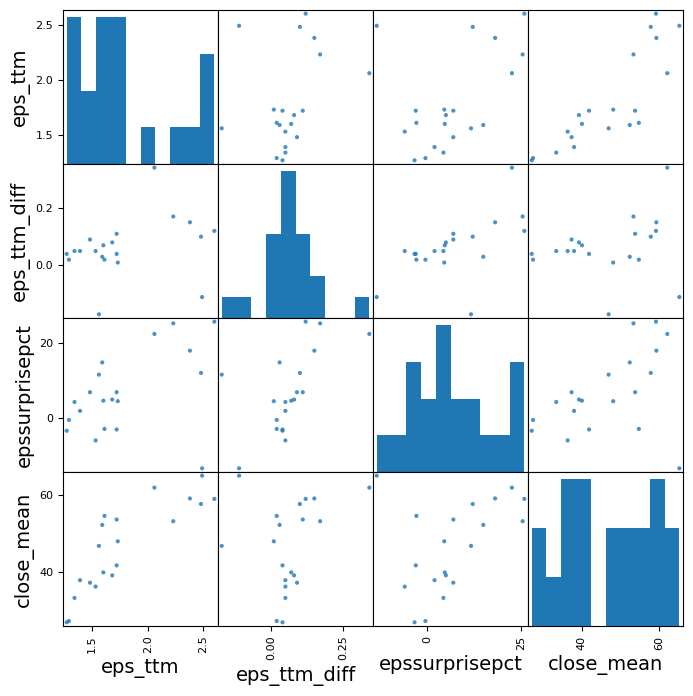

In [70]:
scatter_matrix(price_earning[["eps_ttm",	"eps_ttm_diff",
                              "epssurprisepct",	"close_mean"]],
               alpha = 0.8, figsize = (8, 8), diagonal="hist")
plt.show()

In [71]:
corr = price_earning[["eps_ttm",	"eps_ttm_diff",
                      "epssurprisepct",	"close_mean"]].corr()
corr

,eps_ttm,eps_ttm_diff,epssurprisepct,close_mean
eps_ttm,1.000000,0.277617,0.458074,0.845375
eps_ttm_diff,0.277617,1.000000,0.593368,0.225704
epssurprisepct,0.458074,0.593368,1.000000,0.434751
close_mean,0.845375,0.225704,0.434751,1.000000


In [72]:
model = ols(
    "close_mean ~ eps_ttm + eps_ttm_diff + epssurprisepct",
    data=price_earning
    ).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             close_mean   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     13.69
Date:                Fri, 22 Nov 2024   Prob (F-statistic):           0.000110
Time:                        15:20:48   Log-Likelihood:                -64.071
No. Observations:                  20   AIC:                             136.1
Df Residuals:                      16   BIC:                             140.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          6.8524      6.929      0.989      0.337      -7.836      21.541
eps_ttm           22.1003      4.022      5.495      0.000      13.574      30.627
eps_ttm_diff      -6.4763     18.642     -0.347      0.733     -45.995      33.043
epssurprisepct     0.1020      0.193      0.528      0.605      -0.308       0.512
==============================================================================
Omnibus:                        2.323   Durbin-Watson:                   0.684
Prob(Omnibus):                  0.313   Jarque-Bera (JB):                1.926
Skew:                           0.675   Prob(JB):                        0.382
Kurtosis:                       2.301   Cond. No.                         156.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [73]:
model = ols("close_mean ~ eps_ttm", data=price_earning).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             close_mean   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     45.08
Date:                Fri, 22 Nov 2024   Prob (F-statistic):           2.70e-06
Time:                        15:20:48   Log-Likelihood:                -64.246
No. Observations:                  20   AIC:                             132.5
Df Residuals:                      18   BIC:                             134.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.8312      6.241      0.934      0.363      -7.282      18.944
eps_ttm       22.8328      3.401      6.714      0.000      15.688      29.977
==============================================================================
Omnibus:                        2.478   Durbin-Watson:                   0.550
Prob(Omnibus):                  0.290   Jarque-Bera (JB):                1.973
Skew:                           0.649   Prob(JB):                        0.373
Kurtosis:                       2.173   Cond. No.                         10.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [74]:
pickle.dump(model, open("model.pickle", "wb"))

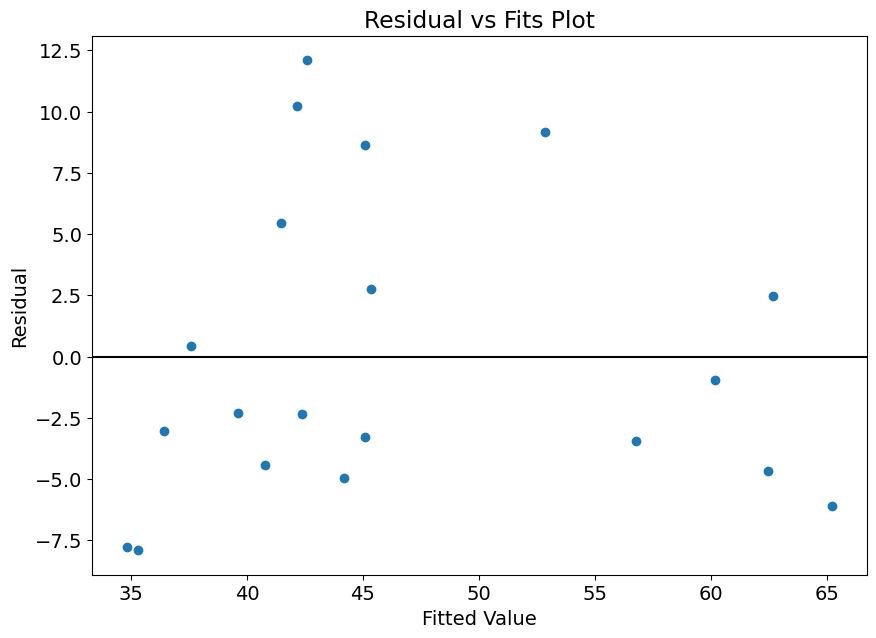

In [75]:
fitted = model.fittedvalues
resid = model.resid
fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(fitted, resid)
ax.axhline(y = 0, color = 'black', linestyle = 'solid')
ax.set(xlabel="Fitted Value", ylabel="Residual", title="Residual vs Fits Plot")
plt.show()

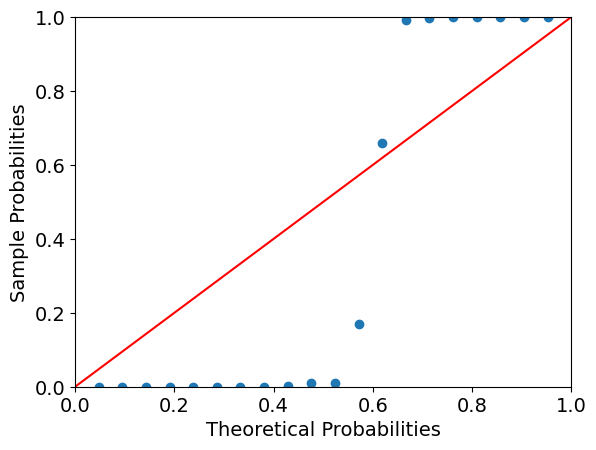

In [76]:
residuals = model.resid
pplot = sm.ProbPlot(residuals)
fig = pplot.ppplot(line="45")
plt.show()

## numpy

In [77]:
arr = np.array([[1, 2],
                [2, 1]])

In [78]:
X = price_earning[["eps_ttm",
                   "eps_ttm_diff",
                   "epssurprisepct"]].values
y = price_earning[["close_mean"]].values
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

In [79]:
arr.shape, X.shape, y.shape

((2, 2), (20, 3), (20, 1))

In [80]:
X_t = X.transpose()
X_t.shape

(3, 20)

In [81]:
arr + np.array([[1, 0],
                [0, 1]])

array([[2, 2],
       [2, 2]])

In [82]:
arr - np.array([[1, 0],
                [0, 1]])

array([[0, 2],
       [2, 0]])

In [83]:
arr * np.array([[1, 0],
                [0, 1]])

array([[1, 0],
       [0, 1]])

In [84]:
arr / np.array([[2, 1],
                [1, 2]])

array([[0.5, 2. ],
       [2. , 0.5]])

In [85]:
np.matmul(arr, np.array([[1, 0],
                         [0, 1]]))

array([[1, 2],
       [2, 1]])

In [86]:
np.ones((5, 1))

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [87]:
X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
X

array([[ 1.000e+00,  2.490e+00, -1.100e-01, -1.329e+01],
       [ 1.000e+00,  2.600e+00,  1.200e-01,  2.578e+01],
       [ 1.000e+00,  2.480e+00,  1.000e-01,  1.212e+01],
       [ 1.000e+00,  2.380e+00,  1.500e-01,  1.805e+01],
       [ 1.000e+00,  2.230e+00,  1.700e-01,  2.532e+01],
       [ 1.000e+00,  2.060e+00,  3.400e-01,  2.250e+01],
       [ 1.000e+00,  1.720e+00,  1.100e-01,  6.990e+00],
       [ 1.000e+00,  1.610e+00,  2.000e-02, -2.800e+00],
       [ 1.000e+00,  1.590e+00,  3.000e-02,  1.491e+01],
       [ 1.000e+00,  1.560e+00, -1.700e-01,  1.167e+01],
       [ 1.000e+00,  1.730e+00,  1.000e-02,  4.590e+00],
       [ 1.000e+00,  1.720e+00,  4.000e-02, -2.950e+00],
       [ 1.000e+00,  1.680e+00,  8.000e-02,  5.020e+00],
       [ 1.000e+00,  1.600e+00,  7.000e-02,  4.720e+00],
       [ 1.000e+00,  1.530e+00,  5.000e-02, -5.870e+00],
       [ 1.000e+00,  1.480e+00,  9.000e-02,  6.980e+00],
       [ 1.000e+00,  1.390e+00,  5.000e-02,  2.010e+00],
       [ 1.000e+00,  1.340e+00,

In [88]:
X_t = X.transpose()
X_t_X = np.matmul(X_t, X)
X_t_X_inv = np.linalg.inv(X_t_X)
X_t_X_inv_X_t = np.matmul(X_t_X_inv, X_t)
coef = np.matmul(X_t_X_inv_X_t, y)
coef

array([[ 6.85237092],
       [22.10033166],
       [-6.47625745],
       [ 0.1020489 ]])

In [89]:
X = price_earning[["eps_ttm",
                   "eps_ttm_diff",
                   "epssurprisepct"]].values
np.mean(X, axis=0), np.var(X, axis=0)

(array([1.7875, 0.063 , 6.822 ]),
 array([1.73508750e-01, 9.85100000e-03, 1.07008366e+02]))

In [90]:
np.mean(X[:, 0]), np.mean(X[:, 1]), np.mean(X[:, 2])

(1.7875, 0.06300000000000001, 6.822)

In [91]:
arr = np.array([[1, 2],
                [2, 1]])
arr + 1

array([[2, 3],
       [3, 2]])

In [92]:
X_mean = np.mean(X, axis=0)
X_mean.shape, X.shape

((3,), (20, 3))

In [93]:
X_center = X - X_mean
X_center.shape

(20, 3)

In [94]:
np.std(X, axis=0)

array([ 0.41654382,  0.0992522 , 10.34448481])

In [95]:
A = X_center / np.std(X, axis=0)
A.shape

(20, 3)

In [96]:
U, S, V_t = np.linalg.svd(A)

In [97]:
S

array([6.1616955 , 3.83287581, 2.70971798])

In [98]:
V = V_t.transpose()
V

array([[-0.50525198, -0.81155298,  0.29343176],
       [-0.57888616,  0.57090505,  0.5822012 ],
       [-0.64000879,  0.12429473, -0.75824769]])

In [99]:
transformed = np.matmul(A, V)

In [100]:
transformed[:2]

array([[ 1.4012331 , -2.60544583,  0.95427885],
       [-2.49090635, -1.02733649, -0.48290017]])

In [101]:
pca = PCA(n_components=3)
pca.fit(A)

PCA(n_components=3)

In [102]:
pca.singular_values_

array([6.1616955 , 3.83287581, 2.70971798])

In [103]:
pca.components_

array([[ 0.50525198,  0.57888616,  0.64000879],
       [ 0.81155298, -0.57090505, -0.12429473],
       [-0.29343176, -0.5822012 ,  0.75824769]])

In [104]:
pca.transform(A)[:2]

array([[-1.4012331 ,  2.60544583, -0.95427885],
       [ 2.49090635,  1.02733649,  0.48290017]])

# matplotlib을 통한 데이터 시각화



## 산점도

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [106]:
price_earning = pd.read_csv("price_earning.csv")

In [107]:
price_earning.sort_values(by="month",
                          ascending=True,
                          inplace=True)
price_earning.reset_index(drop=True, inplace=True)
price_earning.head()

,month,eps_ttm,eps_ttm_diff,epssurprisepct,close_mean
0,2015-02,1.27,0.04,-3.28,27.049290
1,2015-05,1.29,0.02,-0.40,27.383825
2,2015-08,1.34,0.05,4.37,33.382857
3,2015-11,1.39,0.05,2.01,37.981950
4,2016-03,1.48,0.09,6.98,37.339364


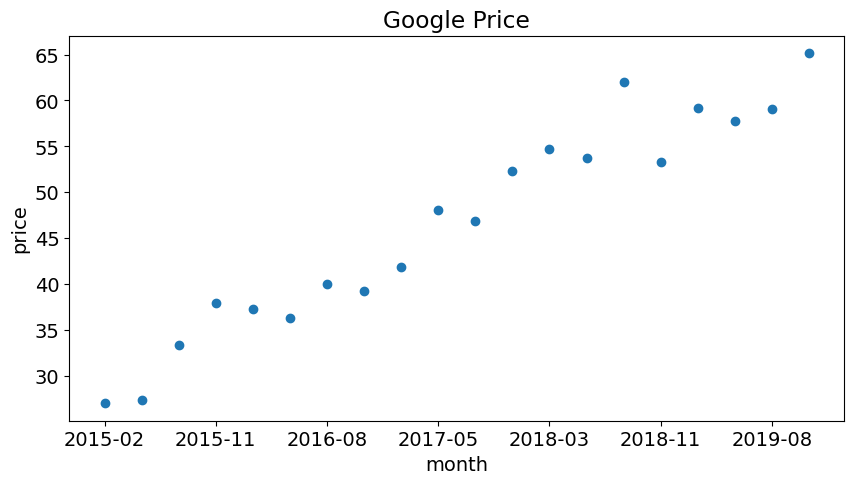

In [108]:
fig = plt.figure(figsize=(10, 5))
ax = plt.axes()
ax.scatter(price_earning["month"], price_earning["close_mean"])
ax.set(xlabel='month', ylabel='price', title='Google Price')
ax.set_xticks(price_earning["month"][np.arange(0, len(price_earning), step=3)])
plt.show()

In [109]:
sns.set_theme(style="whitegrid")

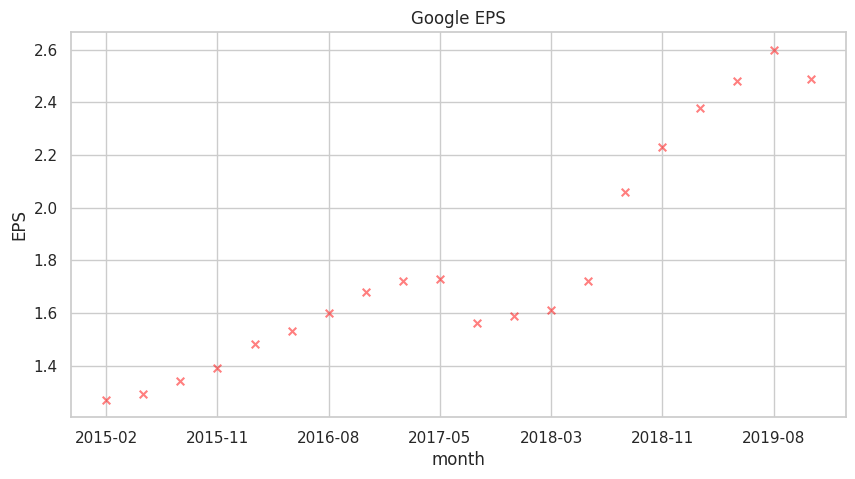

In [110]:
fig = plt.figure(figsize=(10, 5))
ax = plt.axes()
ax.scatter(price_earning["month"], price_earning["eps_ttm"],
           s=30, c="red", marker="x", alpha=0.5)
ax.set(xlabel='month', ylabel='EPS', title='Google EPS')
ax.set_xticks(price_earning["month"][np.arange(0, len(price_earning), step=3)])
plt.show()

## 서브 플롯

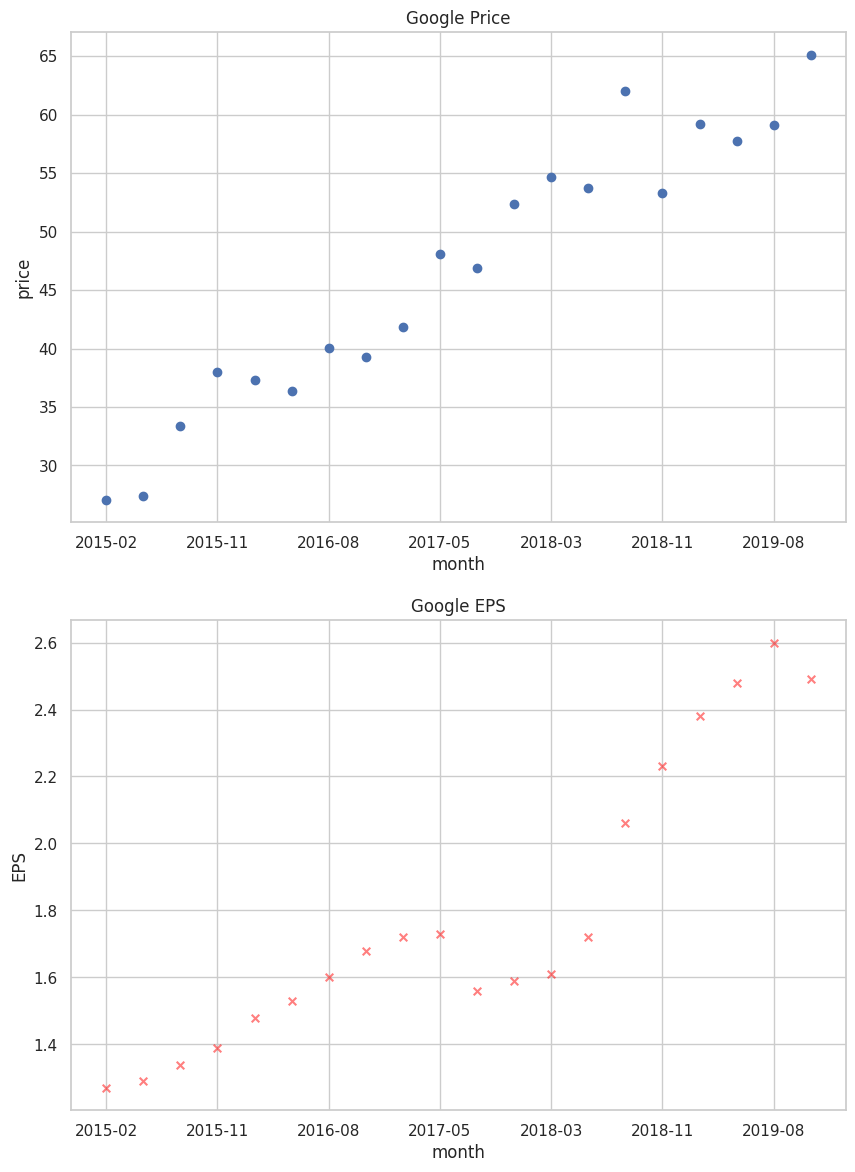

In [111]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 14))
ax1.scatter(price_earning["month"], price_earning["close_mean"])
ax1.set(xlabel='month', ylabel='price', title='Google Price')
ax1.set_xticks(price_earning["month"][np.arange(0, len(price_earning), step=3)])
ax2.scatter(price_earning["month"], price_earning["eps_ttm"],
           s=30, c="red", marker="x", alpha=0.5)
ax2.set(xlabel='month', ylabel='EPS', title='Google EPS')
ax2.set_xticks(price_earning["month"][np.arange(0, len(price_earning), step=3)])
plt.show()

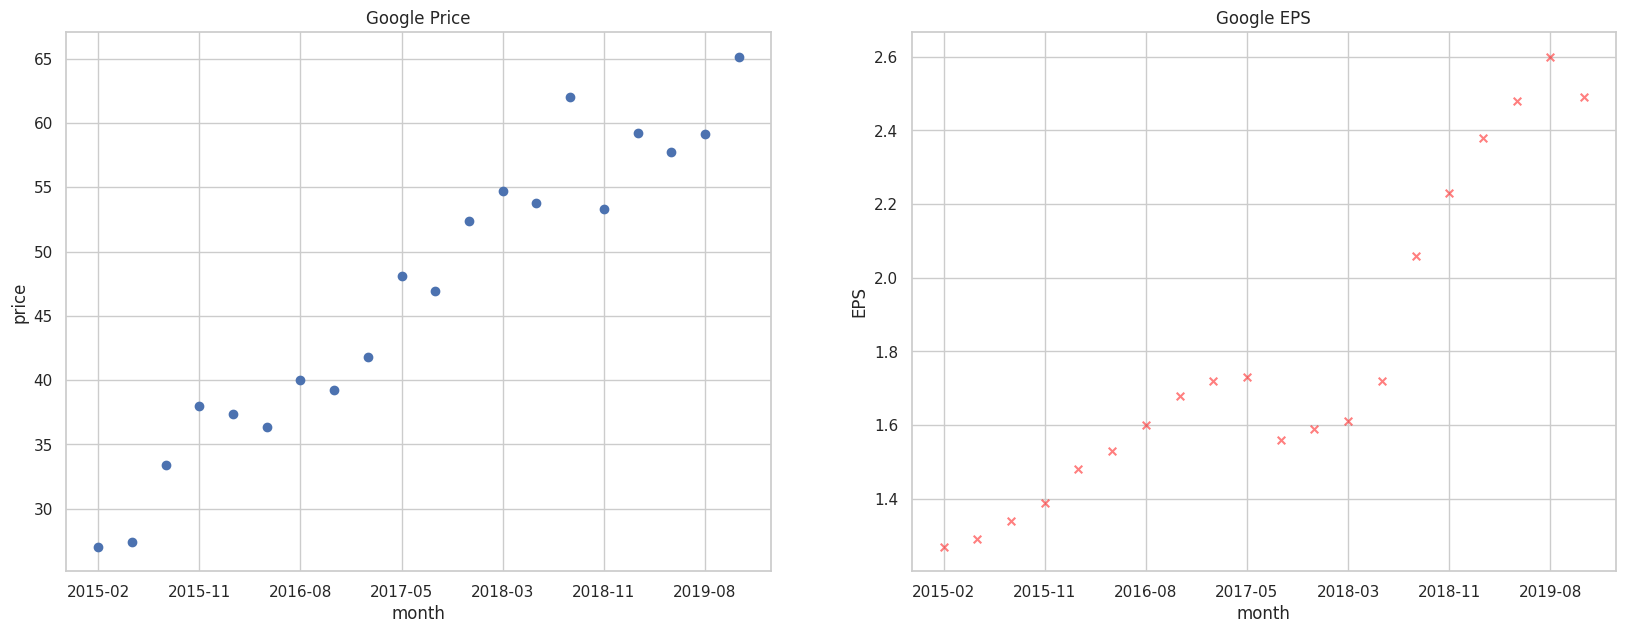

In [112]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))
ax1.scatter(price_earning["month"], price_earning["close_mean"])
ax1.set(xlabel='month', ylabel='price', title='Google Price')
ax1.set_xticks(price_earning["month"][np.arange(0, len(price_earning), step=3)])
ax2.scatter(price_earning["month"], price_earning["eps_ttm"],
           s=30, c="red", marker="x", alpha=0.5)
ax2.set(xlabel='month', ylabel='EPS', title='Google EPS')
ax2.set_xticks(price_earning["month"][np.arange(0, len(price_earning), step=3)])
plt.show()

In [113]:
np.arange(0, len(price_earning), step=3)

array([ 0,  3,  6,  9, 12, 15, 18])

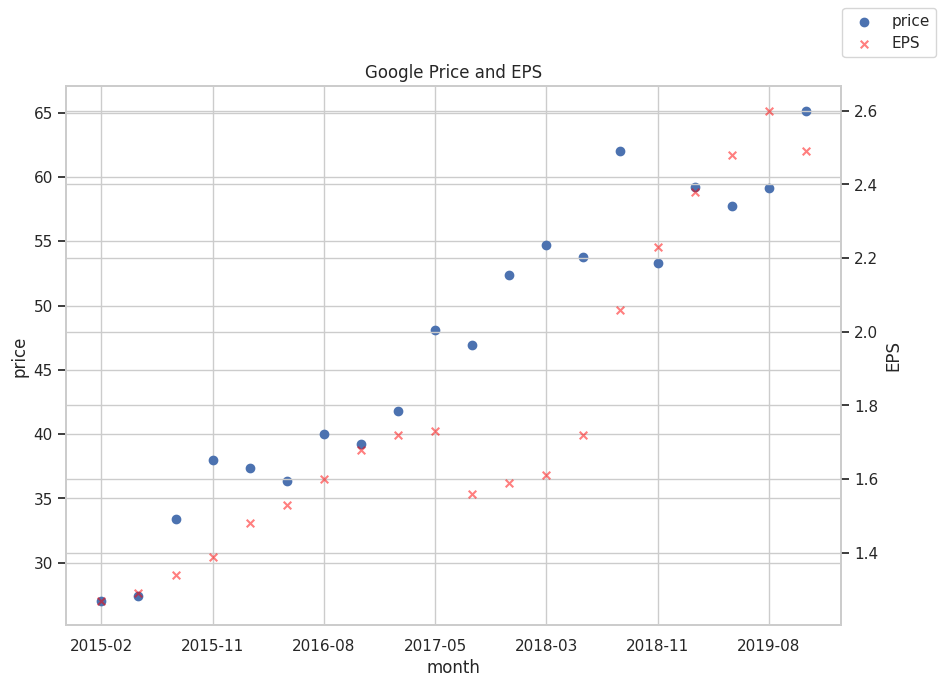

In [114]:
fig, ax1 = plt.subplots(figsize=(10, 7))
ax1.scatter(price_earning["month"], price_earning["close_mean"],
            label="price")
ax1.set_xlabel("month")
ax1.set_ylabel("price")
ax1.set_title("Google Price and EPS")
ax1.set_xticks(price_earning["month"][np.arange(0, len(price_earning), step=3)])

ax2 = ax1.twinx()
ax2.scatter(price_earning["month"], price_earning["eps_ttm"],
            label="EPS", s=30, c="red", marker="x", alpha=0.5)
ax2.set_ylabel("EPS")
ax2.set_xticks(price_earning["month"][np.arange(0, len(price_earning), step=3)])

fig.legend(loc="upper right")
plt.show()

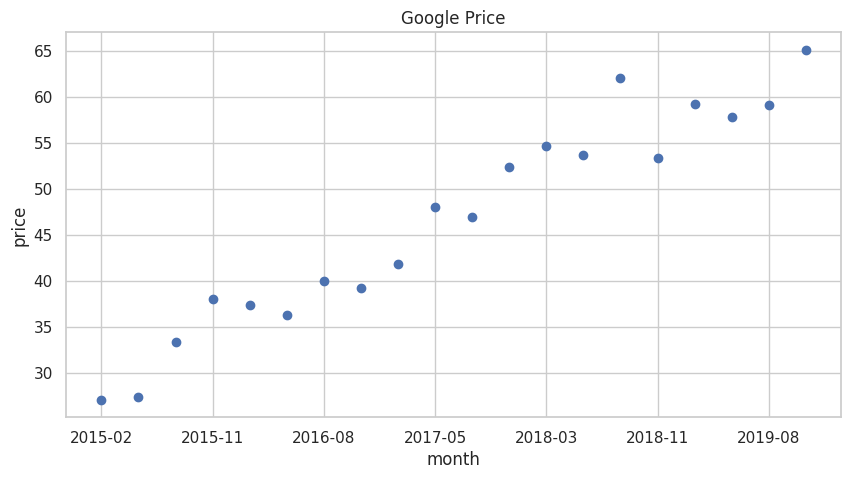

In [115]:
# fig = plt.figure(figsize=(10, 5))
# ax = plt.axes()
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(price_earning["month"], price_earning["close_mean"])
ax.set(xlabel='month', ylabel='price', title='Google Price')
ax.set_xticks(price_earning["month"][np.arange(0, len(price_earning), step=3)])
plt.show()

## 선 그래프

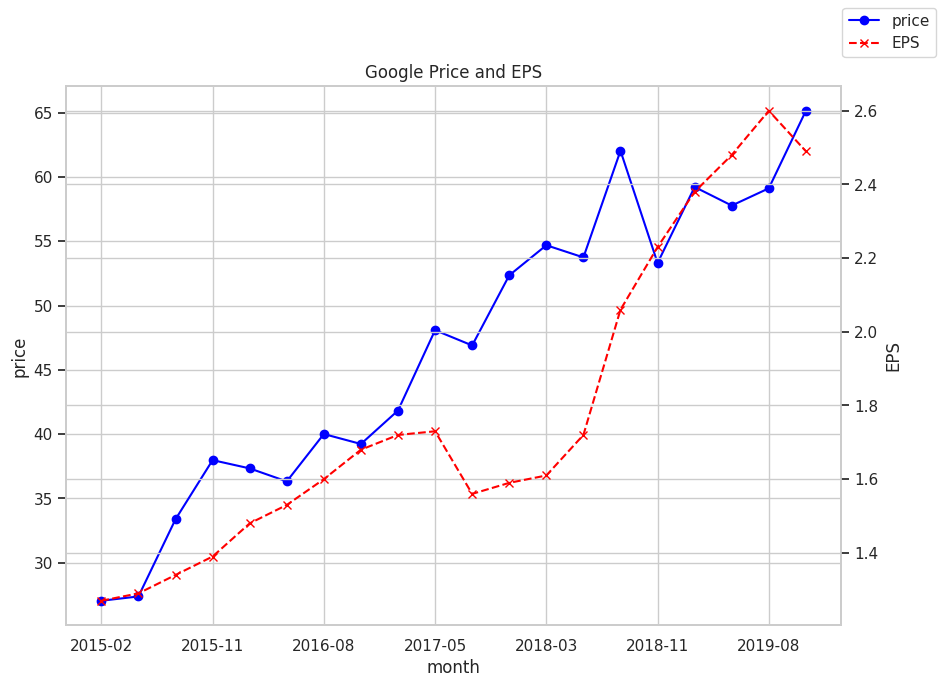

In [116]:
fig, ax1 = plt.subplots(figsize=(10, 7))
ax1.plot(price_earning["month"], price_earning["close_mean"],
         label="price", marker="o", c="blue", linestyle="solid")
ax1.set_xlabel("month")
ax1.set_ylabel("price")
ax1.set_title("Google Price and EPS")
ax1.set_xticks(price_earning["month"][np.arange(0, len(price_earning), step=3)])

ax2 = ax1.twinx()
ax2.plot(price_earning["month"], price_earning["eps_ttm"],
         label="EPS", marker="x", c="red", linestyle="dashed")
ax2.set_ylabel("EPS")
ax2.set_xticks(price_earning["month"][np.arange(0, len(price_earning), step=3)])

fig.legend(loc="upper right")
plt.show()

In [117]:
model = pickle.load(open("model.pickle", "rb"))

In [118]:
model.params

,0
Intercept,5.831214
eps_ttm,22.832824


In [119]:
b1, b0 = model.params["eps_ttm"], model.params["Intercept"]

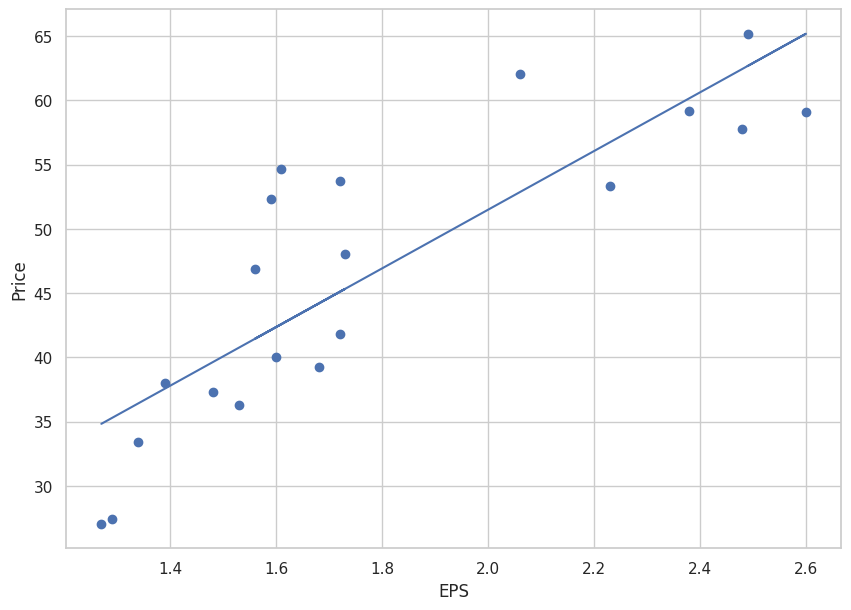

In [120]:
fig, ax = plt.subplots(figsize=(10, 7))
x = price_earning["eps_ttm"]
y = price_earning["close_mean"]
ax.scatter(x, y)
ax.plot(x, b1 * x + b0)
ax.set(xlabel='EPS', ylabel='Price')
plt.show()

In [121]:
prediction = (model
              .get_prediction(price_earning)
              .summary_frame(alpha=0.05))
prediction

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,34.828901,2.259072,30.082766,39.575035,20.699074,48.958727
1,35.285557,2.206503,30.649866,39.921248,21.192444,49.378670
2,36.427198,2.079003,32.059375,40.795021,22.419912,50.434485
3,37.568839,1.957976,33.455284,41.682394,23.638745,51.498934
4,39.623794,1.760661,35.924781,43.322806,25.810435,53.437153
5,40.765435,1.665306,37.266758,44.264112,27.004369,54.526501
6,42.363733,1.553390,39.100181,45.627284,28.660559,56.066906
7,44.190359,1.462911,41.116896,47.263821,30.531209,57.849508
8,45.103671,1.434977,42.088896,48.118447,31.457607,58.749736
9,45.332000,1.429932,42.327824,48.336175,31.688273,58.975726


In [122]:
price_earning["eps_ttm"].mean(), price_earning["close_mean"].mean()

(1.7875, 46.644887118999236)

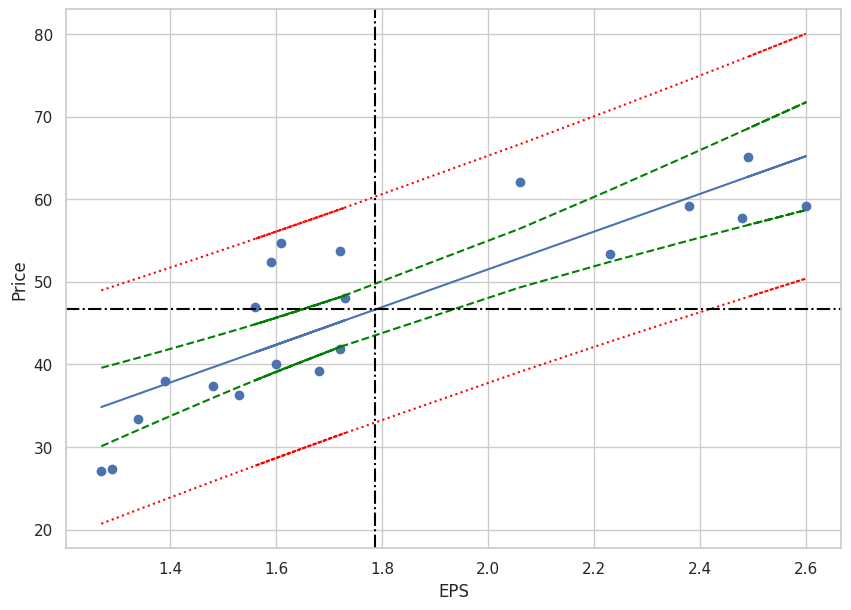

In [123]:
fig, ax = plt.subplots(figsize=(10, 7))
x = price_earning["eps_ttm"]
y = price_earning["close_mean"]
ax.scatter(x, y)
ax.plot(x, b1 * x + b0)
ax.plot(x, prediction["mean_ci_lower"], c="green",
        linestyle="dashed")
ax.plot(x, prediction["mean_ci_upper"], c="green",
        linestyle="dashed")
ax.plot(x, prediction["obs_ci_upper"], c="red", linestyle="dotted")
ax.plot(x, prediction["obs_ci_lower"], c="red", linestyle="dotted")
ax.axhline(np.mean(y), c="black", linestyle="dashdot")
ax.axvline(np.mean(x), c="black", linestyle="dashdot")
ax.set(xlabel='EPS', ylabel='Price')
plt.show()

## 막대 그래프

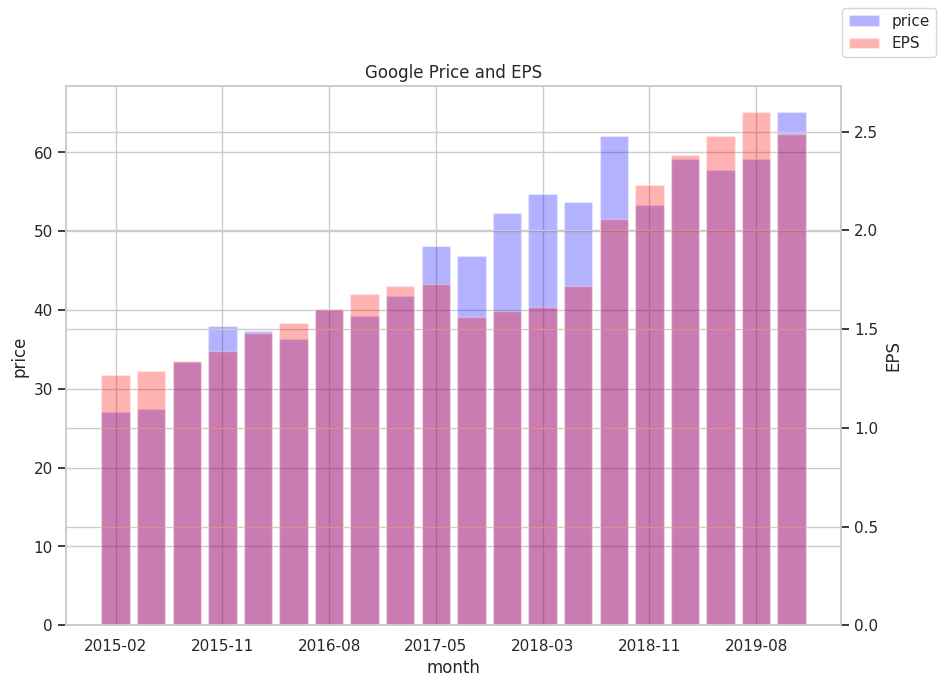

In [124]:
fig, ax1 = plt.subplots(figsize=(10, 7))
ax1.bar(price_earning["month"], price_earning["close_mean"],
        label="price", color="blue", alpha=0.3)
ax1.set_xlabel("month")
ax1.set_ylabel("price")
ax1.set_title("Google Price and EPS")
ax1.set_xticks(price_earning["month"][np.arange(0, len(price_earning), step=3)])

ax2 = ax1.twinx()
ax2.bar(price_earning["month"], price_earning["eps_ttm"],
        label="EPS", color="red", alpha=0.3)
ax2.set_ylabel("EPS")
ax2.set_xticks(price_earning["month"][np.arange(0, len(price_earning), step=3)])

fig.legend(loc="upper right")
plt.show()

## 히스토그램

In [125]:
residuals = model.resid

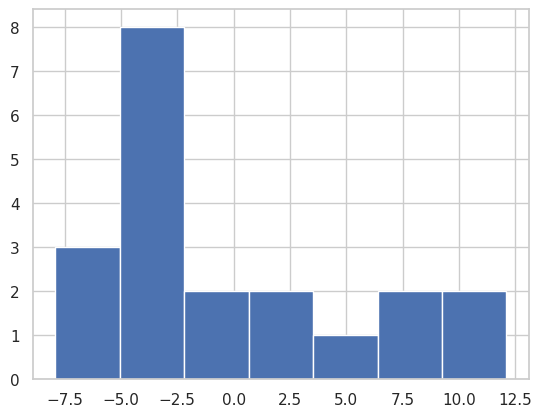

In [126]:
fig, ax = plt.subplots()
ax.hist(residuals, bins=7)
plt.show()

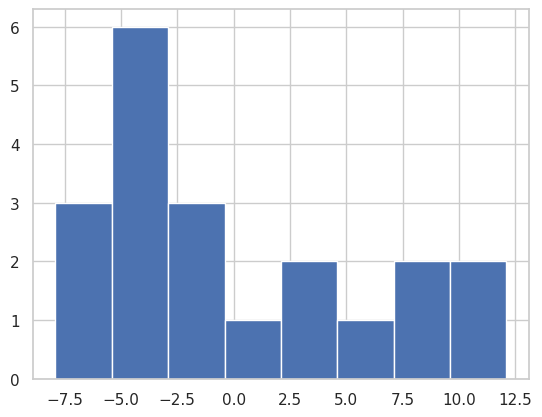

In [127]:
fig, ax = plt.subplots()
ax.hist(residuals, bins=8)
plt.show()

In [128]:
google = pd.read_csv("google_price.csv", index_col=0, parse_dates=True)
fb = pd.read_csv("meta_price.csv", index_col=0, parse_dates=True)
google = google[(google.index > "2020-01-01") &
                (google.index < "2022-01-01")]
fb = fb[(fb.index > "2020-01-01") & (fb.index < "2022-01-01")]

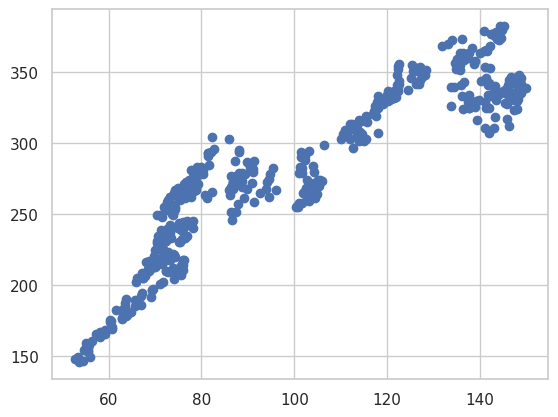

In [129]:
fig, ax = plt.subplots()
ax.scatter(google["close"], fb["close"])
plt.show()

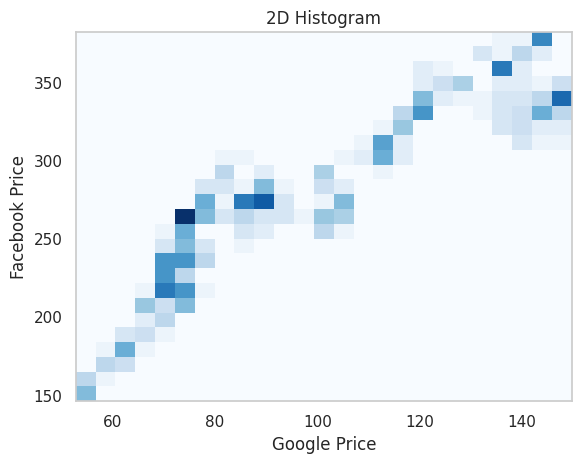

In [130]:
fig, ax = plt.subplots()
ax.hist2d(google["close"], fb["close"], bins=25, cmap='Blues')
ax.set(xlabel='Google Price', ylabel='Facebook Price',
       title='2D Histogram')
plt.show()

## 상자 그림

In [131]:
google = pd.read_csv("google_price.csv", index_col=0, parse_dates=True)
google_2017 = google[(google.index > "2017-01-01") &
                     (google.index < "2018-01-01")]["close"]
google_2018 = google[(google.index > "2018-01-01") &
                     (google.index < "2019-01-01")]["close"]
google_2019 = google[(google.index > "2019-01-01") &
                     (google.index < "2020-01-01")]["close"]
google_2020 = google[(google.index > "2020-01-01") &
                     (google.index < "2021-01-01")]["close"]
google_2021 = google[(google.index > "2021-01-01") &
                     (google.index < "2022-01-01")]["close"]

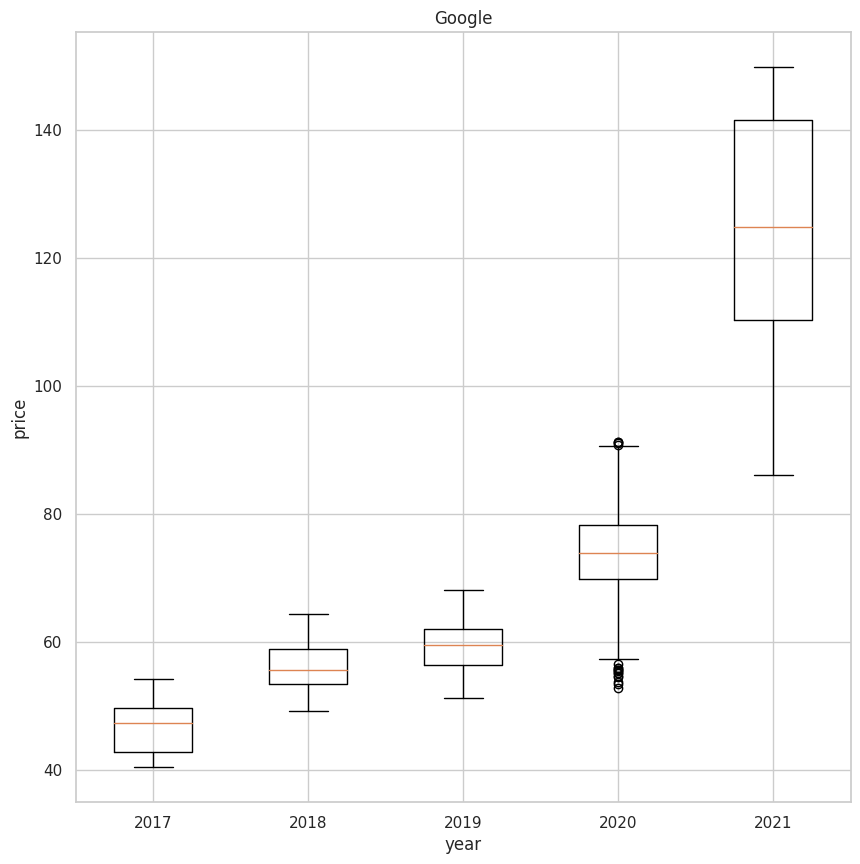

In [132]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.boxplot([google_2017, google_2018, google_2019,
            google_2020, google_2021])
ax.set(xlabel='year', ylabel='price', title='Google')
ax.set_xticklabels(["2017", "2018", "2019", "2020", "2021"])
plt.show()

## 히트맵

In [133]:
price_earning = pd.read_csv("price_earning.csv")
corr = price_earning[["eps_ttm",	"eps_ttm_diff",
                      "epssurprisepct",	"close_mean"]].corr()
corr

,eps_ttm,eps_ttm_diff,epssurprisepct,close_mean
eps_ttm,1.000000,0.277617,0.458074,0.845375
eps_ttm_diff,0.277617,1.000000,0.593368,0.225704
epssurprisepct,0.458074,0.593368,1.000000,0.434751
close_mean,0.845375,0.225704,0.434751,1.000000


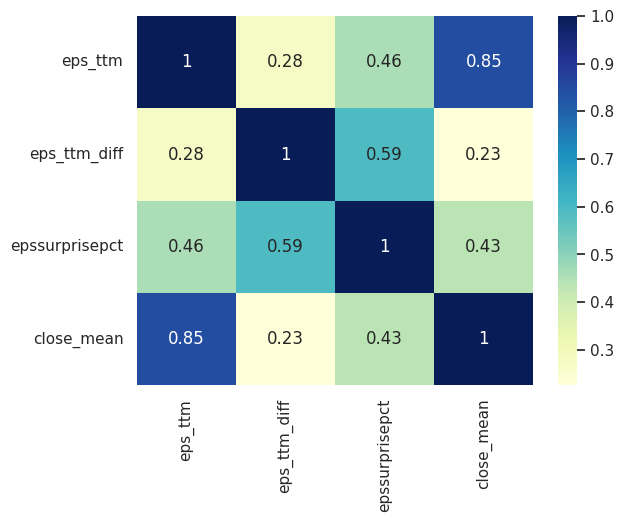

In [134]:
sns.heatmap(corr, cmap="YlGnBu", annot=True)
plt.show()

## 줄기-잎 그림

In [135]:
price_earning

,month,eps_ttm,eps_ttm_diff,epssurprisepct,close_mean
0,2019-11,2.49,-0.11,-13.29,65.143925
1,2019-08,2.60,0.12,25.78,59.113886
2,2019-05,2.48,0.10,12.12,57.772568
3,2019-03,2.38,0.15,18.05,59.216429
4,2018-11,2.23,0.17,25.32,53.308405
5,2018-08,2.06,0.34,22.50,62.032696
6,2018-05,1.72,0.11,6.99,53.742636
7,2018-03,1.61,0.02,-2.80,54.688452
8,2017-11,1.59,0.03,14.91,52.349167
9,2017-08,1.56,-0.17,11.67,46.898044


In [136]:
eps_ttm_diff = price_earning["eps_ttm_diff"]
stem = eps_ttm_diff.map(lambda x: int(x * 10))

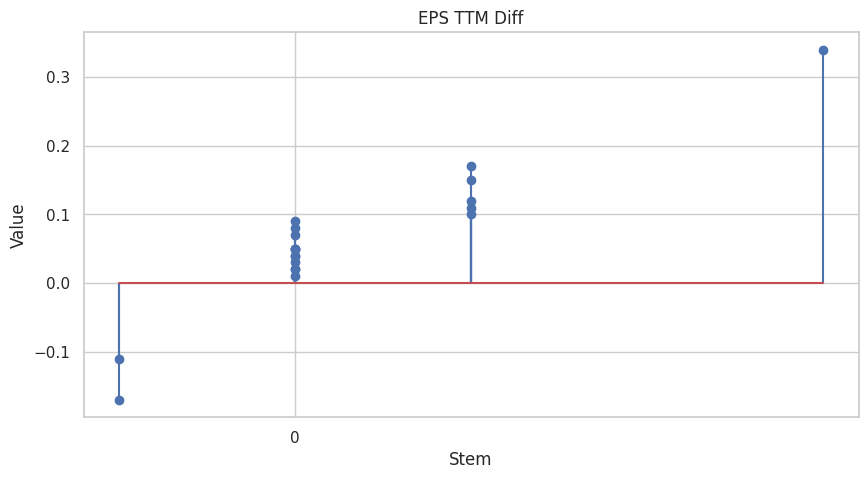

In [137]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.stem(stem, eps_ttm_diff)
ax.set(xlabel='Stem', ylabel='Value', title='EPS TTM Diff')
ax.set_xticks(np.arange(int(eps_ttm_diff.min()),
                        int(eps_ttm_diff.max()) + 1))
plt.show()

In [138]:
pip install stemgraphic

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 3.4 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13704 sha256=6d6669e227df6d9cfe70528dc14e1925cc5f0d56860a588c4ad84e97601bba3b
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [139]:
import stemgraphic

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning:


Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.




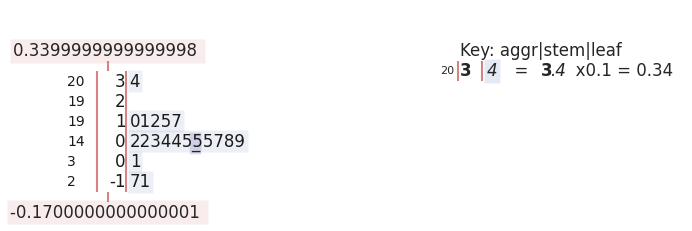

In [140]:
fig, ax = stemgraphic.stem_graphic(
    price_earning["eps_ttm_diff"], scale=0.1)
plt.show()

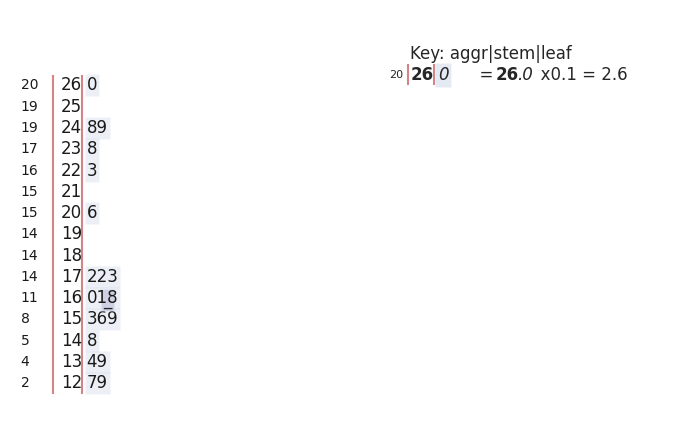

In [141]:
fig, ax = stemgraphic.stem_graphic(
    price_earning["eps_ttm"], scale=0.1)
plt.show()

## 오차 막대 그래프


In [142]:
price_earning["eps_ttm"].mean()

1.7875

In [143]:
price_earning["eps_ttm"].min(), price_earning["eps_ttm"].max()

(1.27, 2.6)

In [144]:
import random
random.seed(8)
random_eps_ttm = [random.uniform(price_earning["eps_ttm"].min() - 20,
                                 price_earning["eps_ttm"].max() + 20)
                  for i in range(10)]
random_eps_ttm = sorted(random_eps_ttm, reverse=False)
random_eps_ttm

[-15.209292871462393,
 -13.508743958759975,
 -10.075595874031235,
 -9.360246831781254,
 -8.503264092880915,
 0.2459984153831556,
 7.79842242153018,
 10.400083422283554,
 21.04165383103504,
 22.56398252358939]

In [145]:
new_observation = pd.DataFrame({"eps_ttm": random_eps_ttm})

In [146]:
prediction = (model
              .get_prediction(new_observation)
              .summary_frame(alpha=0.05))
prediction

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,-341.439899,57.816678,-462.908233,-219.971565,-463.635162,-219.244636
1,-302.611564,52.035717,-411.934550,-193.288579,-412.741676,-192.481453
2,-224.223097,40.366526,-309.030020,-139.416174,-310.067960,-138.378235
3,-207.889658,37.935503,-287.589192,-128.190125,-288.692763,-127.086553
4,-188.322322,35.023447,-261.903853,-114.740790,-263.097772,-113.546871
5,11.448052,5.430044,0.039952,22.856152,-6.081093,28.977198
6,183.891223,20.489775,140.843804,226.938642,138.833410,228.949036
7,243.294492,29.322201,181.690834,304.898149,180.269601,306.319382
8,486.271599,65.491030,348.680051,623.863148,348.037883,624.505316
9,521.030663,70.666741,372.565349,669.495977,371.970019,670.091307


In [147]:
prediction["prediction_error"] = (
    prediction["mean"] - prediction["obs_ci_lower"])
prediction["prediction_error"]

,prediction_error
0,122.195263
1,110.130111
2,85.844863
3,80.803105
4,74.775450
5,17.529145
6,45.057813
7,63.024890
8,138.233716
9,149.060644


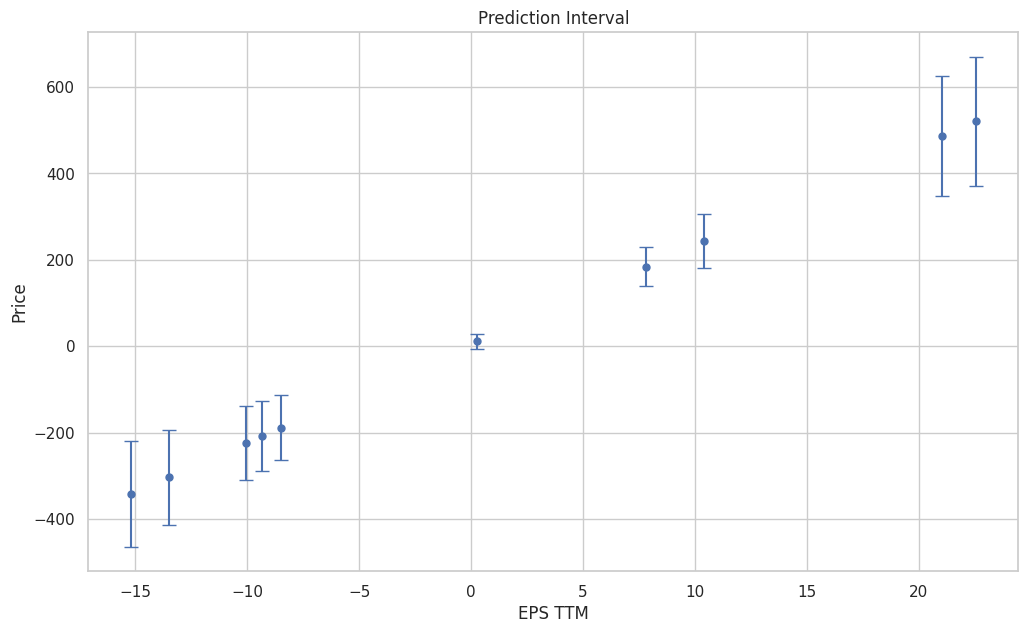

In [148]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.errorbar(x = new_observation["eps_ttm"],
            y = prediction["mean"],
            yerr = prediction["prediction_error"],
            fmt='o', markersize=5, capsize=5)
ax.set(xlabel='EPS TTM', ylabel='Price',
       title='Prediction Interval')
plt.show()